Name: Anindita Bhaumik

ID : 233562415


The aim of the project was to identify the best clustering method by evaluating performance on both the original data and reduced-dimensionality data. The techniques which were tried include K-Means, Spectral Clustering (RBF & NN), Hierarchical Clustering, and Gaussian Mixture Models (GMM). The Dimensionality Reduction was performed using Principal Component Analysis (PCA) and Autoencoder before clustering again using the above-mentioned clustering techniques.

Loading Data Set...
Preprocessing Data...
Clustering on original data:

--- KMeans Clustering ---


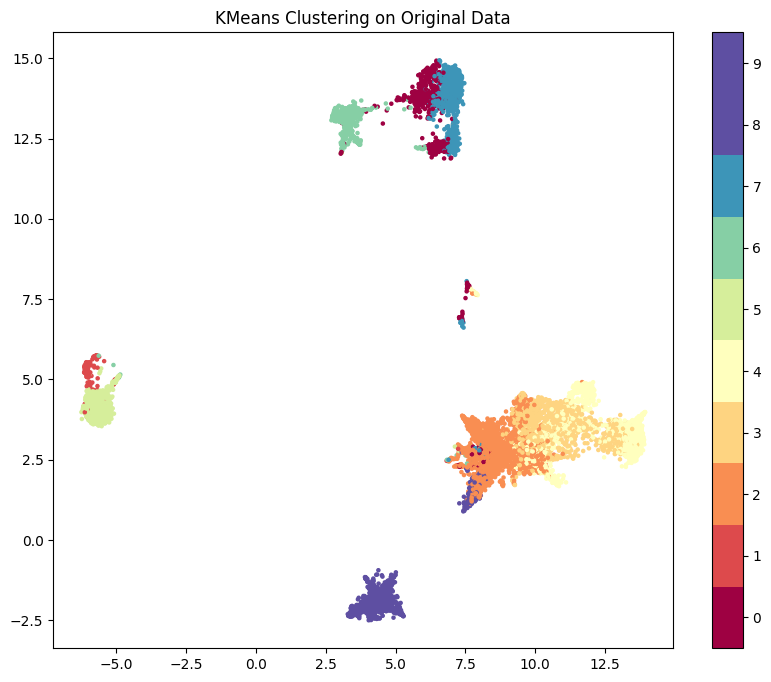


Silhouette Score: 0.0303

--- Hierarchical Clustering ---


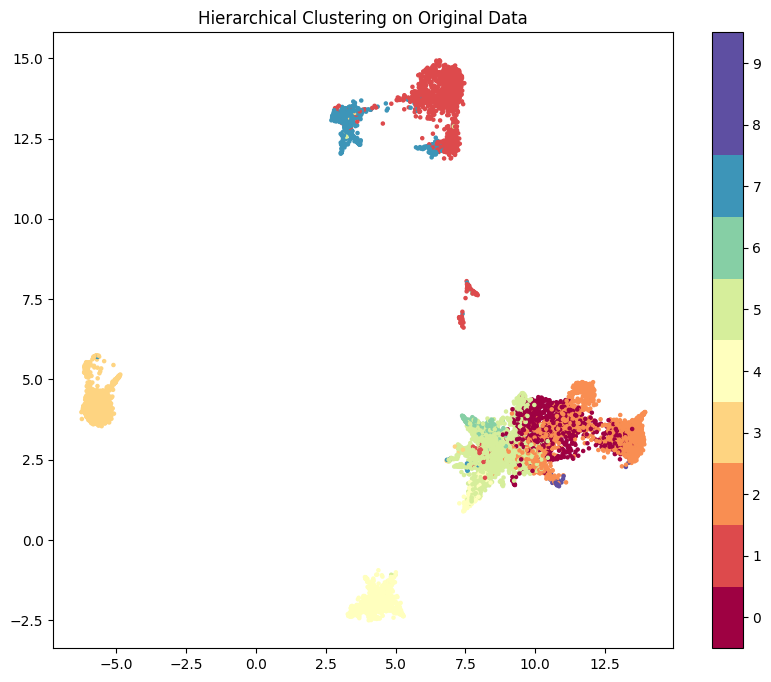


Silhouette Score: 0.0440

--- Spectral-NN Clustering ---


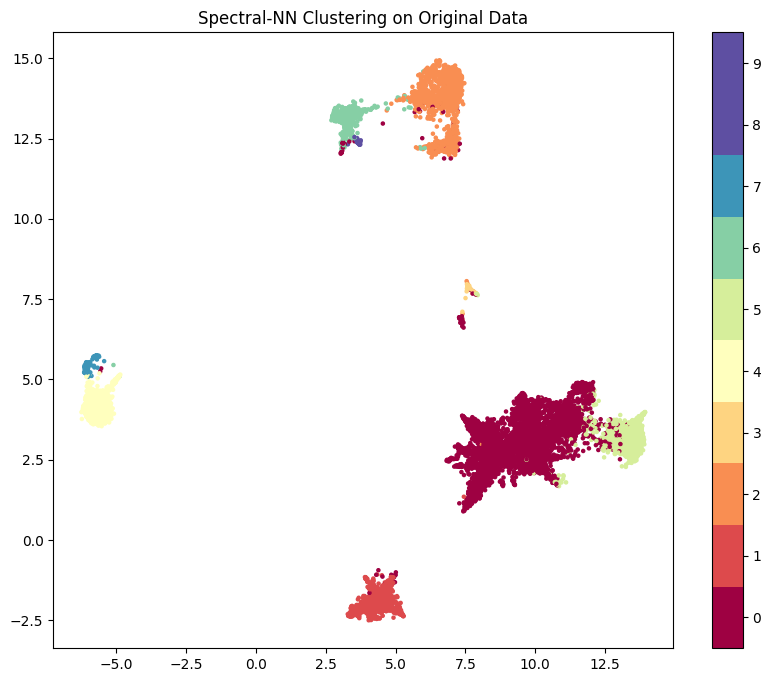


Silhouette Score: -0.0049

--- Spectral-RBF Clustering ---


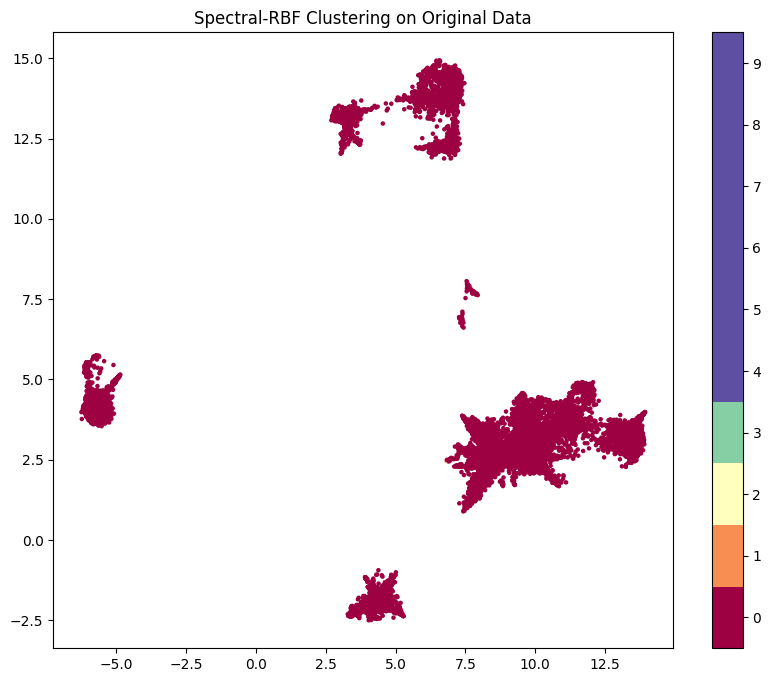


Silhouette Score: 0.6600

--- GMM Clustering ---


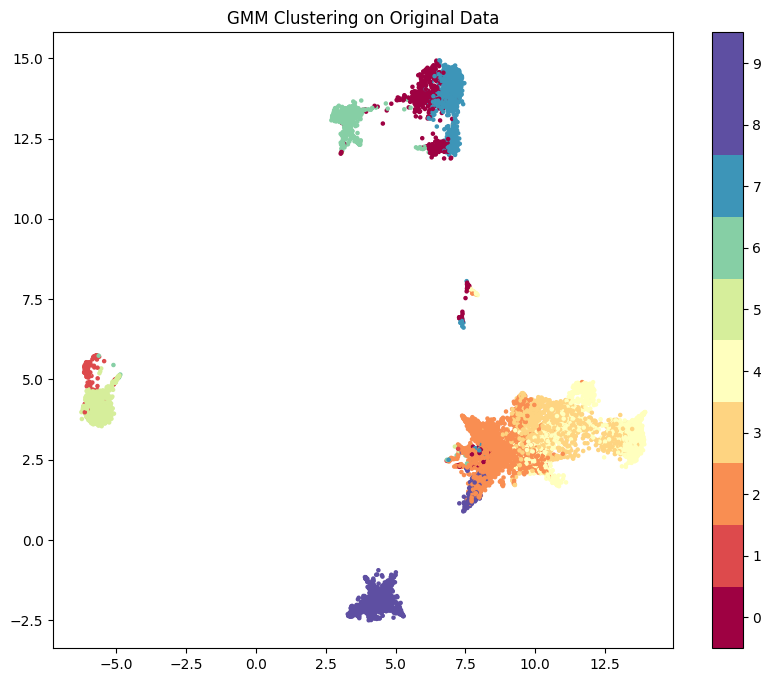


Silhouette Score: 0.0290

Performing dimensionality reduction...
297/297 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

Clustering on reduced data:

--- KMeans Clustering on PCA ---


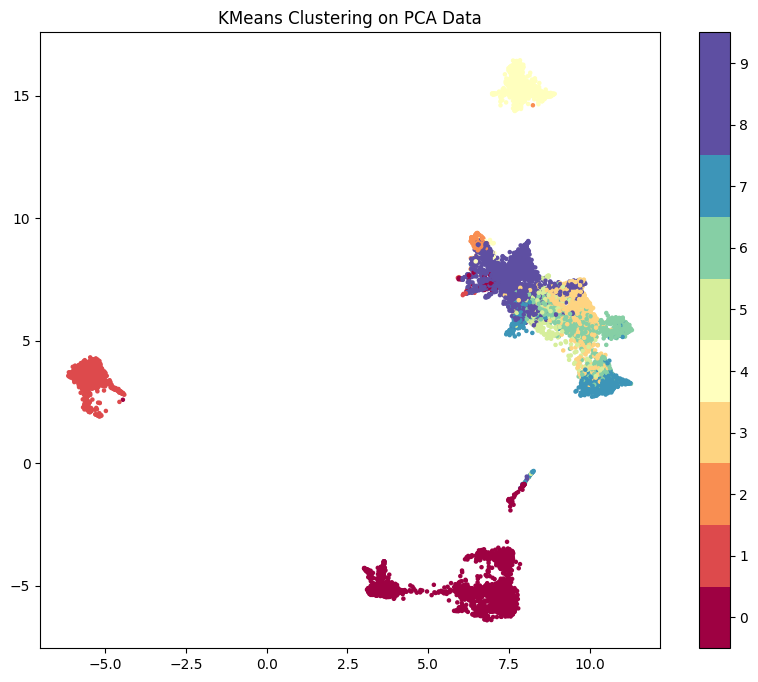


Silhouette Score: 0.0777

--- Hierarchical Clustering on PCA ---


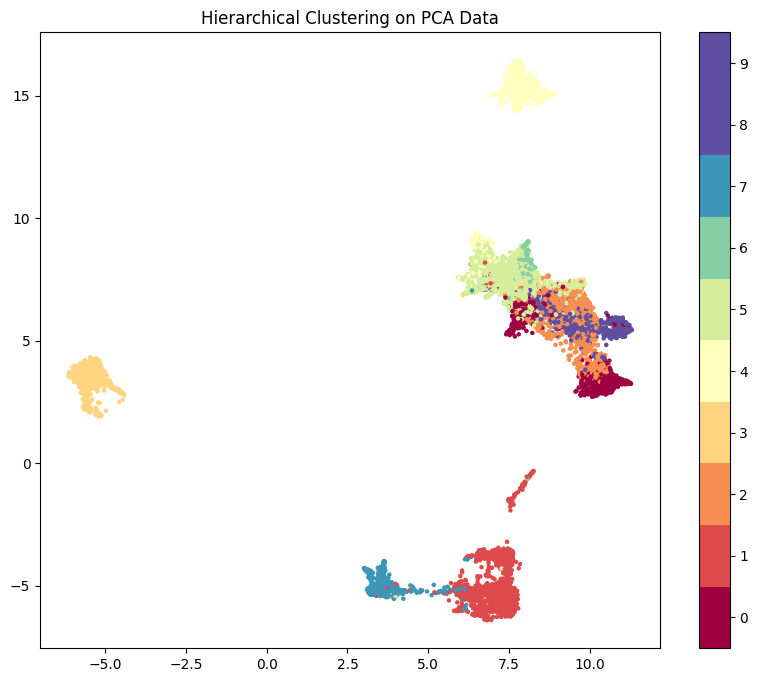


Silhouette Score: 0.0494

--- Spectral-NN Clustering on PCA ---
reduced data shape : (9488, 1022)


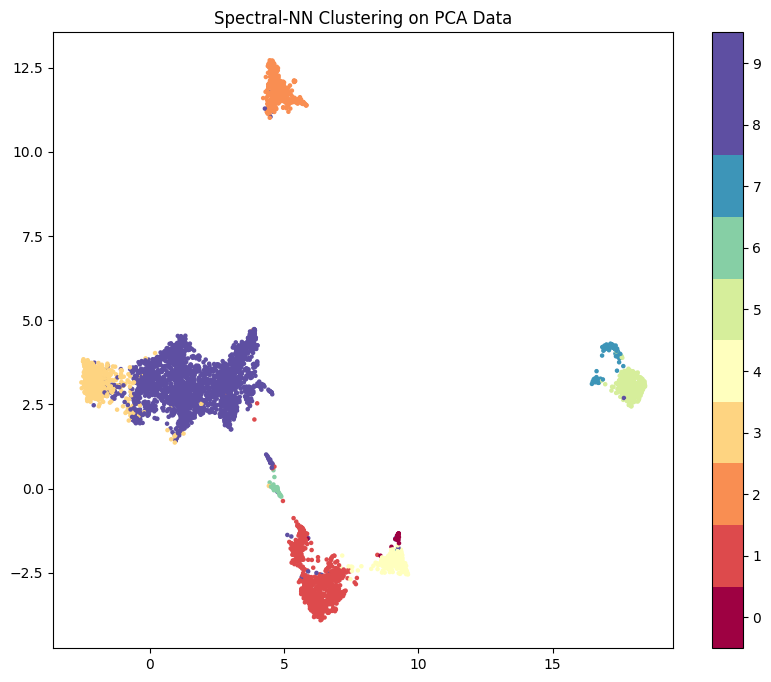


Silhouette Score: -0.0041

--- Spectral-RBF Clustering on PCA ---
reduced data shape : (9488, 1022)


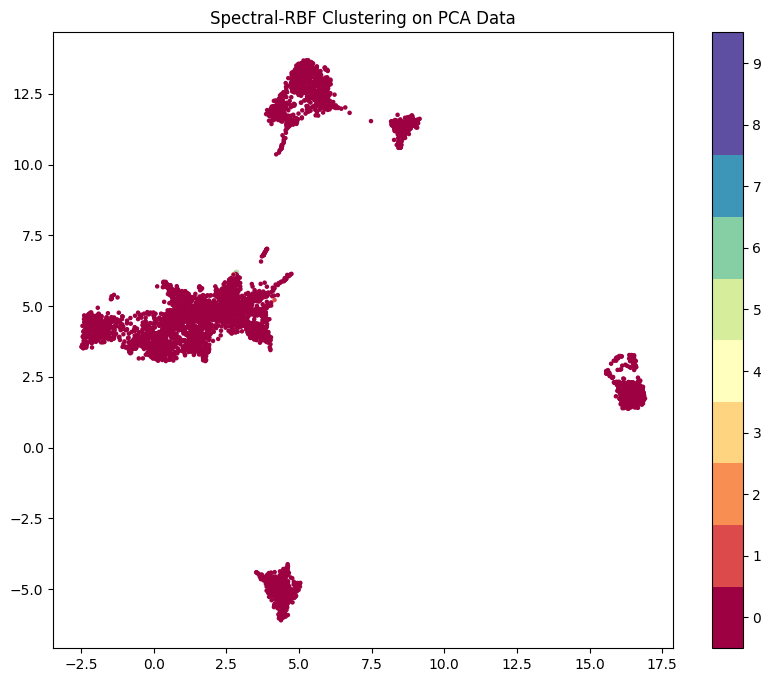


Silhouette Score: 0.3957

--- GMM Clustering on PCA ---


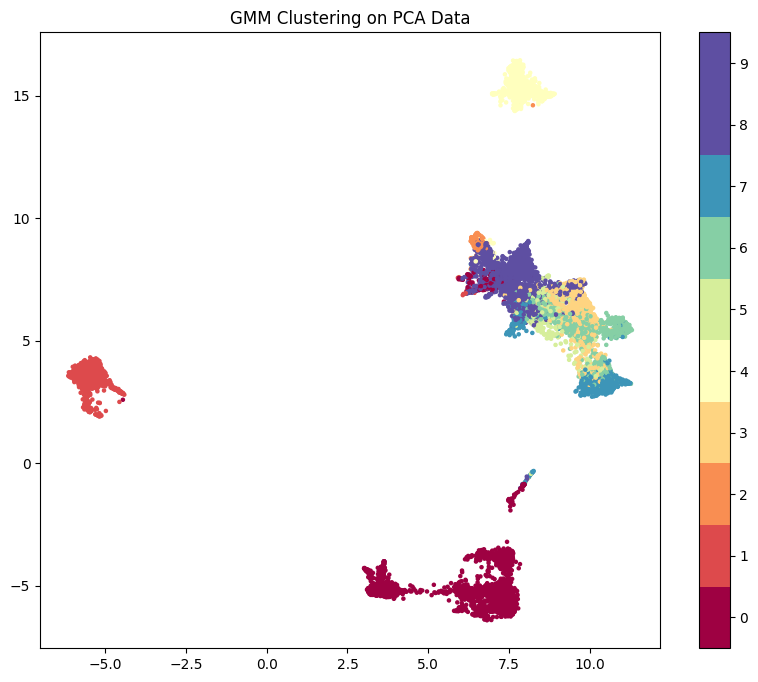


Silhouette Score: 0.0720

--- KMeans Clustering on Autoencoder ---


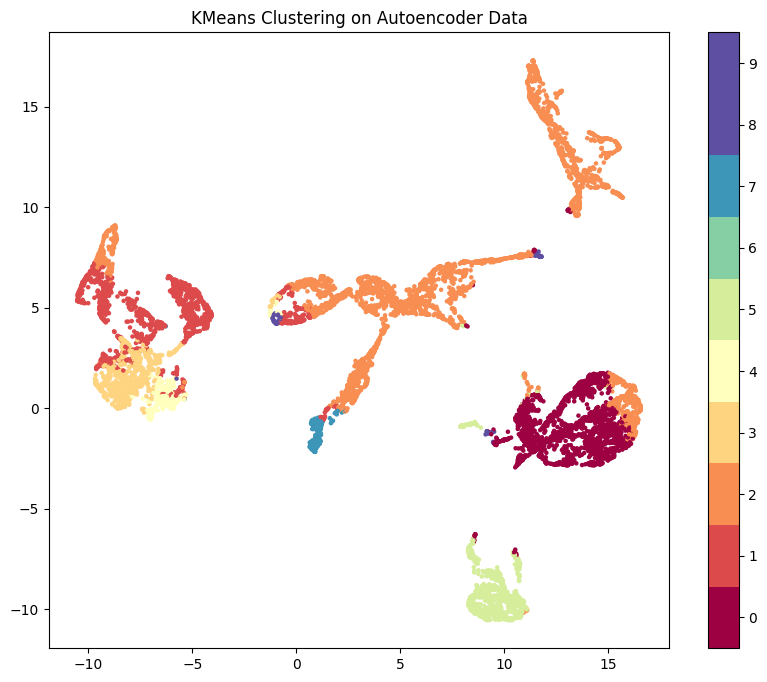


Silhouette Score: 0.3124

--- Hierarchical Clustering on Autoencoder ---


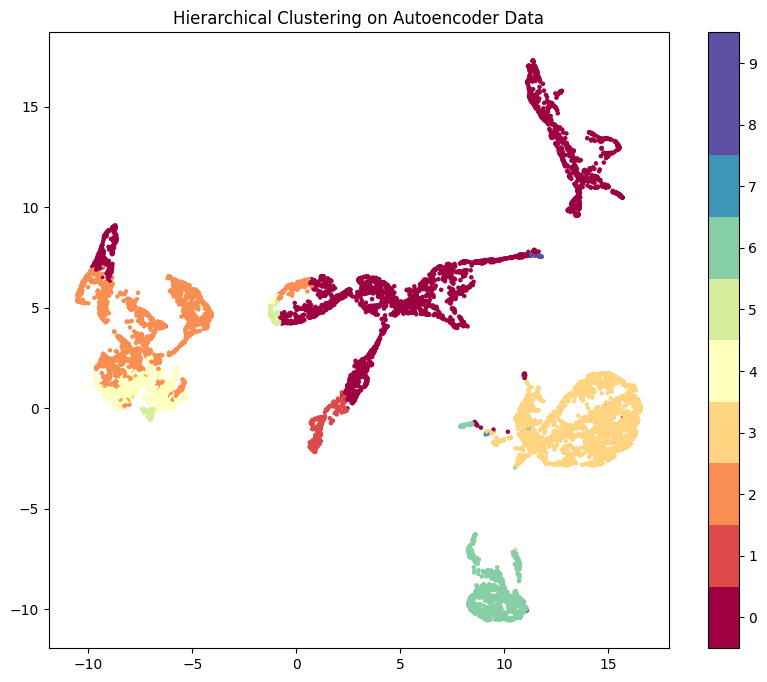


Silhouette Score: 0.2854

--- Spectral-NN Clustering on Autoencoder ---
reduced data shape : (9488, 10)


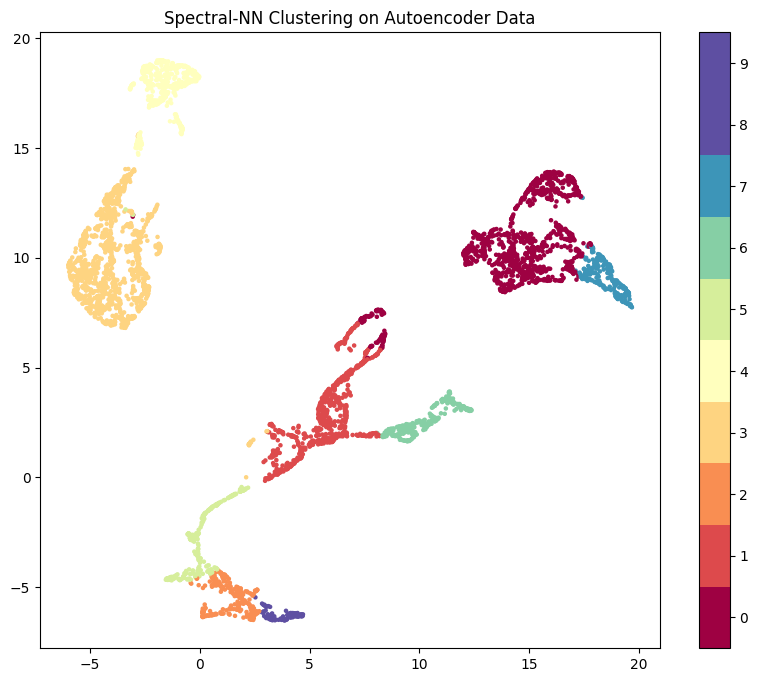


Silhouette Score: 0.0722

--- Spectral-RBF Clustering on Autoencoder ---
reduced data shape : (9488, 10)


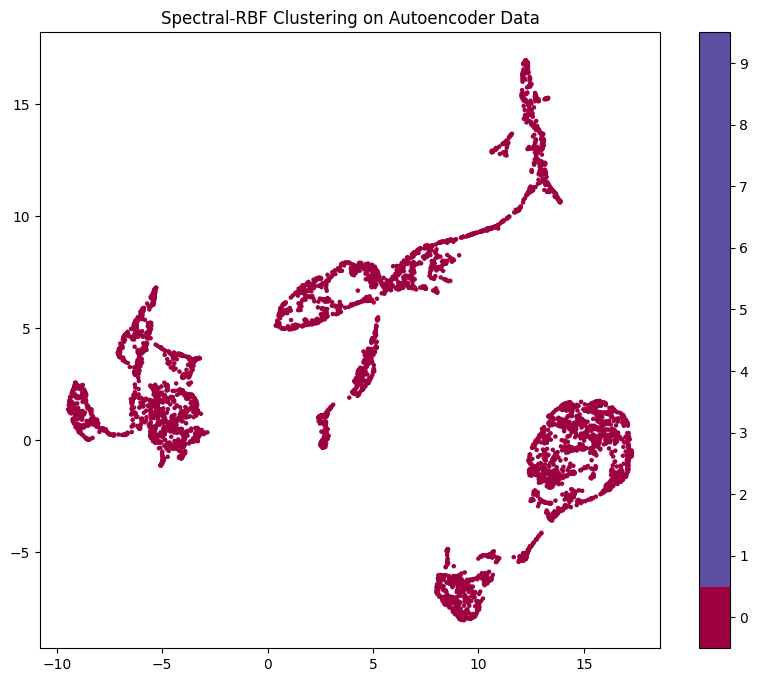


Silhouette Score: 0.9234

--- GMM Clustering on Autoencoder ---


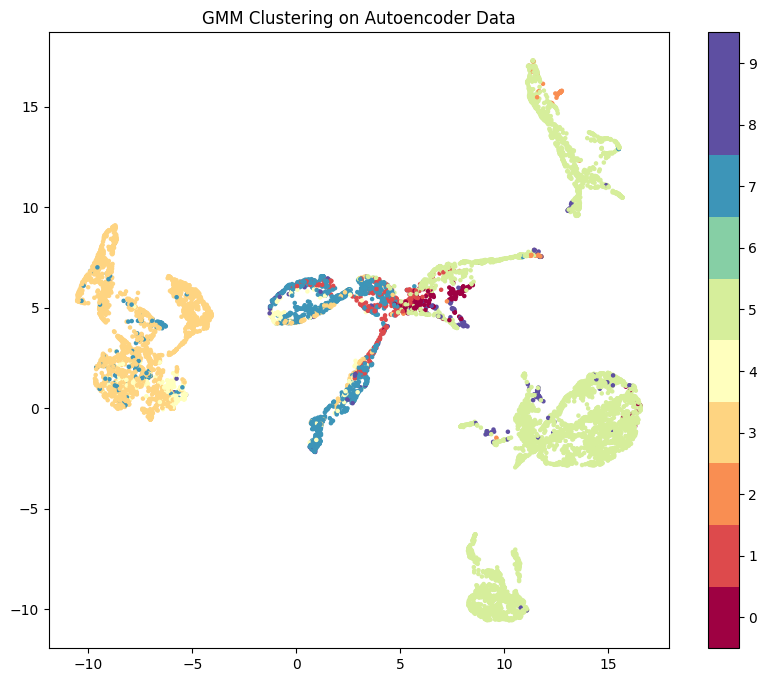


Silhouette Score: -0.1127

Best clustering method: Spectral-RBF on autoencoder data (Score: 0.9234)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score
from umap import UMAP
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Create output directory
def create_output_dir():
    output_dir = 'clustering_outputs'
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(f'{output_dir}/labels', exist_ok=True)
    os.makedirs(f'{output_dir}/plots', exist_ok=True)
    return output_dir

# Loading the dataset
def load_data():
    print("Loading Data Set...")
    ### Loading data set everytime is resource intensive, hence mounted on Google drive
    data = pd.read_csv('/content/drive/MyDrive/Unsupervised learning /data_UL_A1.csv', index_col=0)
    #data =pd.read_csv('/content/data.csv', index_col=0)
    return data

# Preprocessing
def preprocess_data(data):
    print("Preprocessing Data...")
    selector = VarianceThreshold(threshold=0.01)
    data = selector.fit_transform(data)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

# Clustering methods
def kmeans_clustering(data, n_clusters=9):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(data)

def hierarchical_clustering(data, n_clusters=9, linkage='ward'):
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    return agg.fit_predict(data)

def gmm_clustering(data, n_clusters=9):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    return gmm.fit_predict(data)

def spectral_clustering_rbf(data, n_clusters=9, gamma=0.01):
    spectral = SpectralClustering(n_clusters=n_clusters,
                                  affinity='rbf',
                                  gamma=gamma,
                                  random_state=42,
                                  n_jobs=-1)
    return spectral.fit_predict(data)

def spectral_clustering_nn(data, n_clusters=9):
    spectral = SpectralClustering(n_clusters=n_clusters,
                                  affinity='nearest_neighbors',
                                  n_neighbors=10,
                                  random_state=42,
                                  n_jobs=-1)
    return spectral.fit_predict(data)

# Reduce dataset size as it is too large
def reduce_data_size(data, max_samples=5000):
    print("reduced data shape :", data.shape)
    if data.shape[0] > max_samples:
        indices = np.random.choice(data.shape[0], max_samples, replace=False)
        return data[indices], indices
    return data, np.arange(data.shape[0])

# Dimensionality reduction PCA & Aotuencoder
def pca_reduction(data):
    pca = PCA(n_components=0.95)
    return pca.fit_transform(data)

def autoencoder_reduction(data, latent_dim=10, epochs=50):
    input_dim = data.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(500, activation='relu')(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(200, activation='relu')(encoded)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(latent_dim, activation='relu')(encoded)
    decoded = Dense(200, activation='relu')(encoded)
    decoded = Dense(500, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer=Adam(0.001), loss='mse')
    autoencoder.fit(data, data, epochs=epochs, batch_size=256, shuffle=True, verbose=0)
    return encoder.predict(data)

# Visualization
def plot_umap(data, clusters, title, output_dir):
    reducer = UMAP(random_state=42)
    embedding = reducer.fit_transform(data)
    plt.figure(figsize=(10, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='Spectral', s=5)
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.title(title)

    # Save plot
    filename = f"{title.replace(' ', '_').lower()}.png"
    plt.savefig(f"{output_dir}/plots/{filename}", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Save cluster labels
def save_labels(labels, method_name, data_type, output_dir, indices=None, original_indices=None):
    df = pd.DataFrame({'cluster': labels})
    if indices is not None and original_indices is not None:
        df.index = original_indices[indices]
    filename = f"{method_name.lower()}_{data_type}_labels.csv"
    df.to_csv(f"{output_dir}/labels/{filename}")

# Evaluation and saving results
def evaluate_clustering(data, clusters, method_name, data_type, output_dir, results_df):
    score = silhouette_score(data, clusters)
    print(f"\nSilhouette Score: {score:.4f}")


    new_row = pd.DataFrame({
        'method': [method_name],
        'data_type': [data_type],
        'silhouette_score': [score],
        'n_clusters': [len(np.unique(clusters))]
    })
    return pd.concat([results_df, new_row], ignore_index=True)

# Main workflow
def main():
    # Create output directory structure
    output_dir = create_output_dir()

    # Initialize results dataframe
    results_df = pd.DataFrame(columns=['method', 'data_type', 'silhouette_score', 'n_clusters'])

    raw_data = load_data()
    original_indices = raw_data.index
    data = preprocess_data(raw_data)

    print("Clustering on original data:")
    methods = {
        'KMeans': kmeans_clustering,
        'Hierarchical': hierarchical_clustering,
        'Spectral-NN': spectral_clustering_nn,
        'Spectral-RBF': spectral_clustering_rbf,
        'GMM': gmm_clustering
    }

    for name, method in methods.items():
        print(f"\n--- {name} Clustering ---")
        clusters = method(data)
        plot_umap(data, clusters, f"{name} Clustering on Original Data", output_dir)
        save_labels(clusters, name, 'original', output_dir, original_indices=original_indices)
        results_df = evaluate_clustering(data, clusters, name, 'original', output_dir, results_df)

    print("\nPerforming dimensionality reduction...")
    pca_data = pca_reduction(data)
    ae_data = autoencoder_reduction(data)


    def spectral_nn(data):
        return spectral_clustering_nn(data)

    def spectral_rbf(data):
        return spectral_clustering_rbf(data)

    methods_with_spectral = methods.copy()
    methods_with_spectral['Spectral-NN'] = spectral_nn
    methods_with_spectral['Spectral-RBF'] = spectral_rbf

    print("\nClustering on reduced data:")
    for reduced_name, reduced_data in [('PCA', pca_data), ('Autoencoder', ae_data)]:
        for name, method in methods_with_spectral.items():
            print(f"\n--- {name} Clustering on {reduced_name} ---")

            if 'Spectral' in name:
                reduced_data_small, indices = reduce_data_size(reduced_data)
            else:
                reduced_data_small = reduced_data
                indices = np.arange(reduced_data.shape[0])

            clusters = method(reduced_data_small)
            plot_umap(reduced_data_small, clusters, f"{name} Clustering on {reduced_name} Data", output_dir)
            save_labels(clusters, name, reduced_name.lower(), output_dir, indices, original_indices)
            results_df = evaluate_clustering(reduced_data_small, clusters, name, reduced_name.lower(), output_dir, results_df)

    # Save results
    results_df.to_csv(f"{output_dir}/clustering_results.csv", index=False)

    best_result = results_df.loc[results_df['silhouette_score'].idxmax()]
    print(f"\nBest clustering method: {best_result['method']} on {best_result['data_type']} data (Score: {best_result['silhouette_score']:.4f})")

    return results_df

if __name__ == "__main__":
    results = main()

Bonus Question:
Cosine Similarity + Autoencoder

Training Autoencoder...
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Silhouette Score : 0.1663


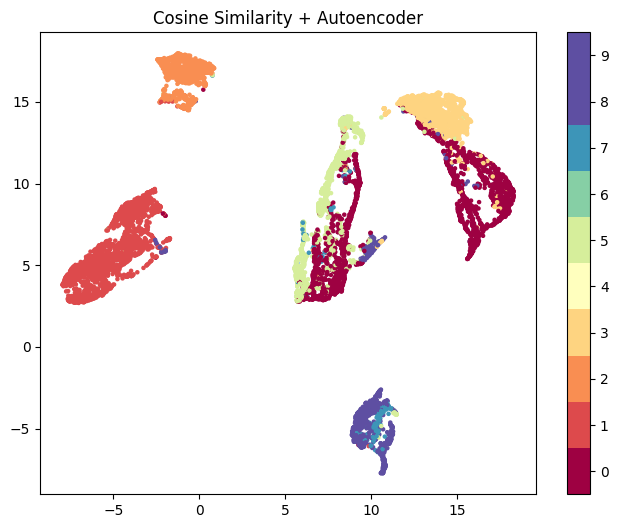

Annotations saved to annotations.csv


In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import umap
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess data
def load_data(filepath='/content/drive/MyDrive/Unsupervised learning /data_UL_A1.csv'):
    df = pd.read_csv(filepath)
    X = df.iloc[1:, 1:].values.astype(float)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

# Autoencoder
def fn_autoencoder(input_dim, latent_dim=10):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(512, activation='relu')(input_layer)
    encoded = Dense(128, activation='relu')(encoded)
    encoded = Dense(latent_dim, activation='relu')(encoded)

    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(512, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)

    autoencoder.compile(optimizer=Adam(0.001), loss='mse')
    return autoencoder, encoder

# Visualize clustering
def visualize_umap(X, labels, title):
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=5)
    plt.title(title)
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.show()

# Save annotations.csv
def save_annotations(labels, filename='annotations.csv'):
    df = pd.DataFrame({
        'Sample_id': np.arange(len(labels)),
        'Cluster_id': labels
    })
    df.to_csv(filename, index=False)
    print(f"Annotations saved to {filename}")

# Cosine Similarity
def cosine_similarity_spectral(X, encoder):

    X_encoded = encoder.predict(X)

    affinity_matrix = cosine_similarity(X_encoded)
    np.fill_diagonal(affinity_matrix, 0)


    spectral = SpectralClustering(n_clusters=9, affinity='precomputed', random_state=42)
    labels = spectral.fit_predict(affinity_matrix)


    silhouette = silhouette_score(X_encoded, labels)
    print(f"Silhouette Score : {silhouette:.4f}")

    visualize_umap(X_encoded, labels, 'Cosine Similarity + Autoencoder')

    save_annotations(labels)
    return labels, silhouette

# Main  workflow
def main():
    X = load_data()

    print("Training Autoencoder...")
    autoencoder, encoder = fn_autoencoder(X.shape[1])
    autoencoder.fit(X, X, epochs=75, batch_size=128, validation_split=0.1, verbose=0)


    labels, score = cosine_similarity_spectral(X, encoder)
    return labels, score

if __name__ == "__main__":
    main()
